heater_patch shape is: (32, 32)
grid shape is: (129, 129)


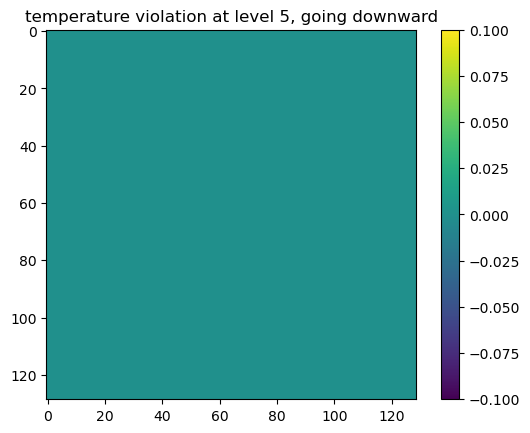

heater_patch shape is: (32, 32)
grid shape is: (129, 129)
restriction step from (129, 129) to (65, 65)
* * * * * * * * * * *


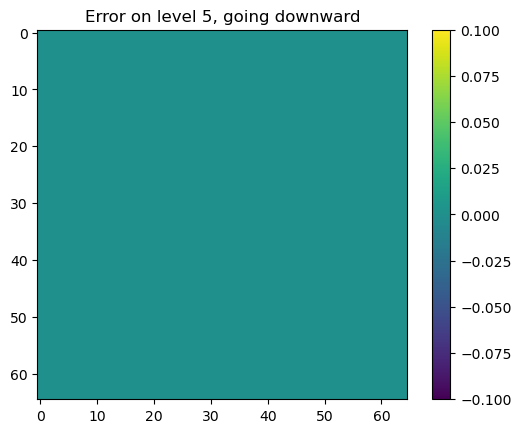

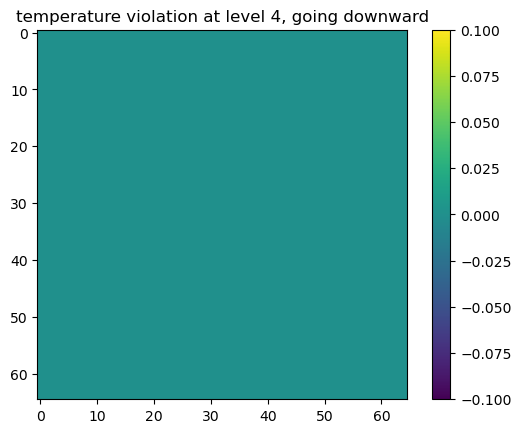

heater_patch shape is: (16, 16)
grid shape is: (65, 65)
restriction step from (65, 65) to (33, 33)
* * * * * * * * * * *


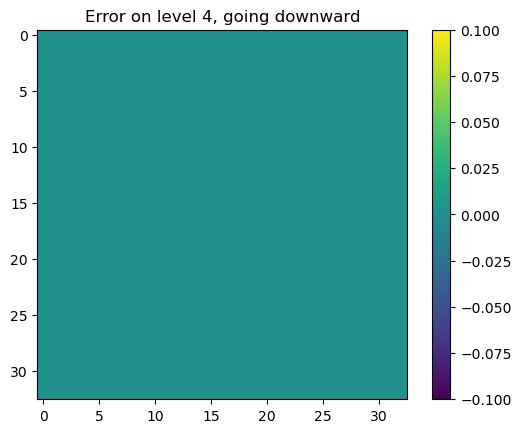

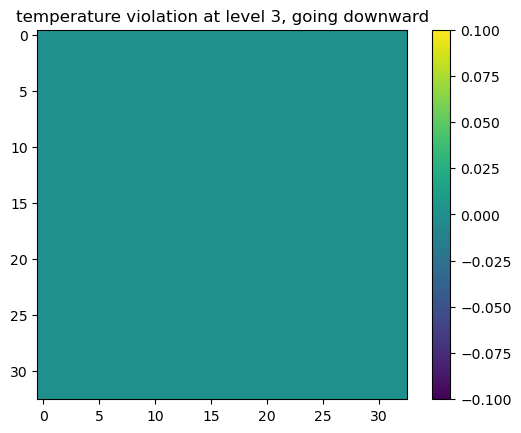

heater_patch shape is: (8, 8)
grid shape is: (33, 33)
restriction step from (33, 33) to (17, 17)
* * * * * * * * * * *


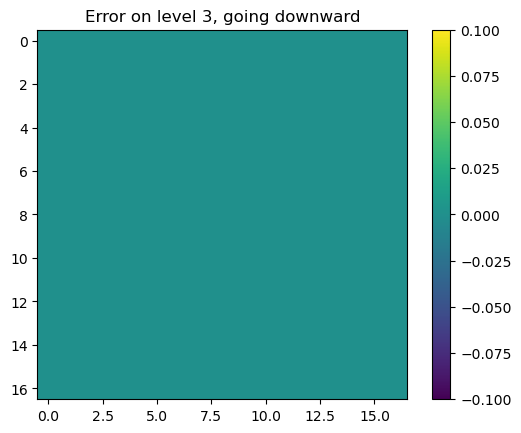

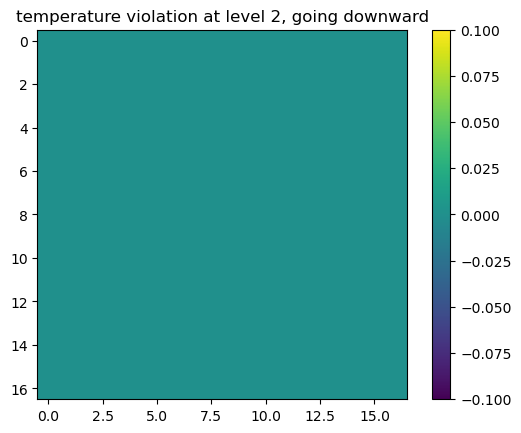

heater_patch shape is: (4, 4)
grid shape is: (17, 17)
restriction step from (17, 17) to (9, 9)
* * * * * * * * * * *


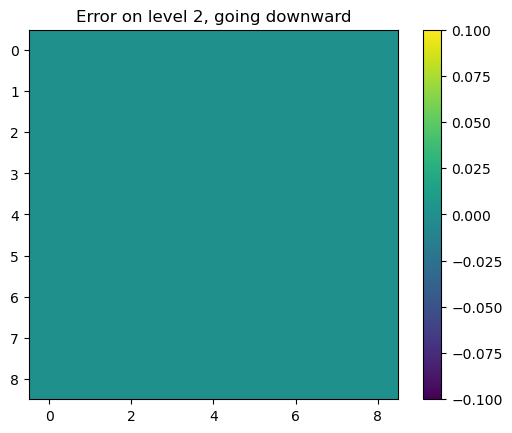

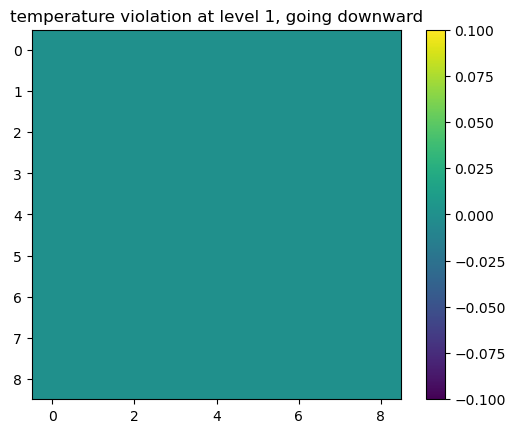

heater_patch shape is: (2, 2)
grid shape is: (9, 9)


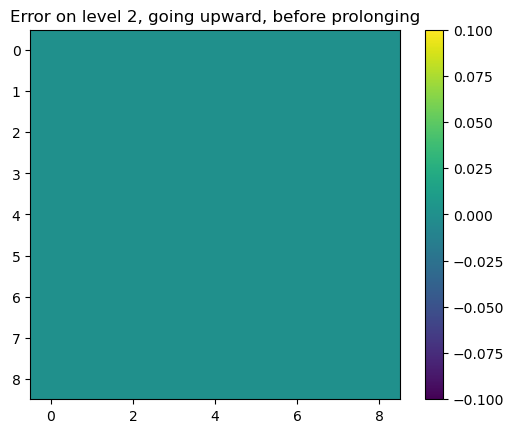

prolongation step from (9, 9) to (17, 17)
* * * * * * * * * * * * * *


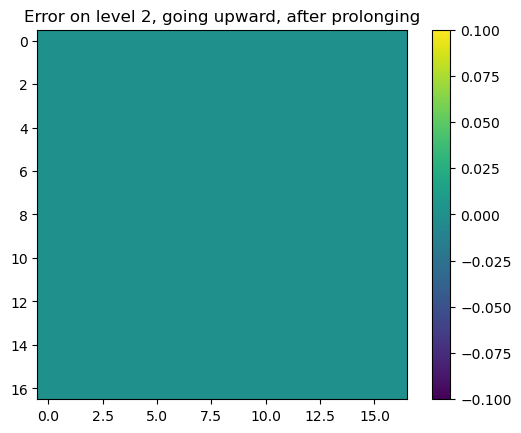

heater_patch shape is: (4, 4)
grid shape is: (17, 17)


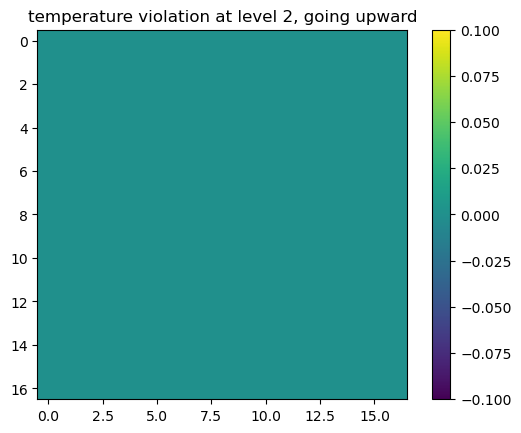

heater_patch shape is: (4, 4)
grid shape is: (17, 17)


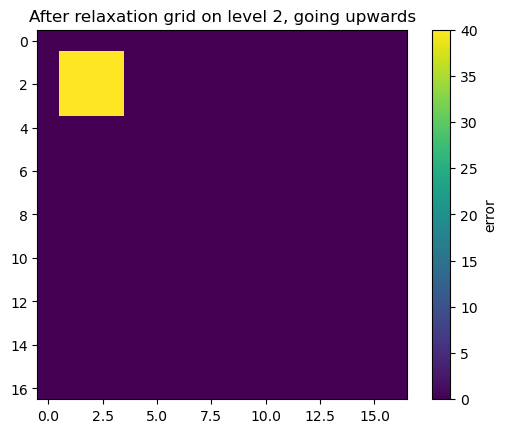

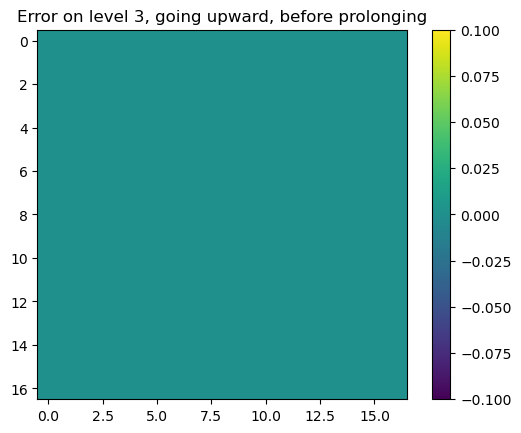

prolongation step from (17, 17) to (33, 33)
* * * * * * * * * * * * * *


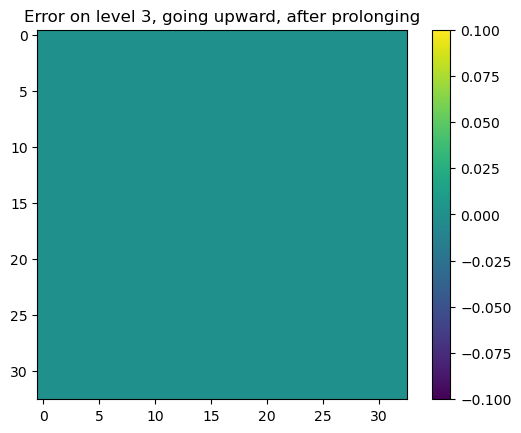

heater_patch shape is: (8, 8)
grid shape is: (33, 33)


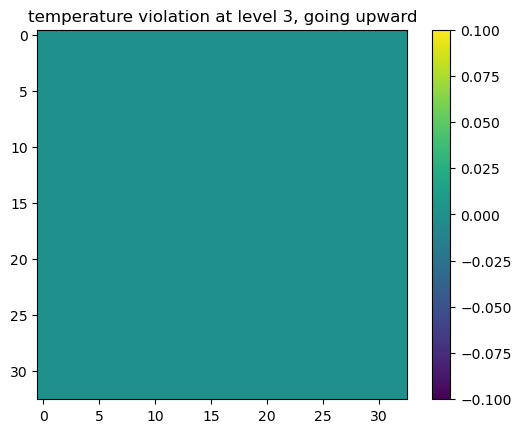

heater_patch shape is: (8, 8)
grid shape is: (33, 33)


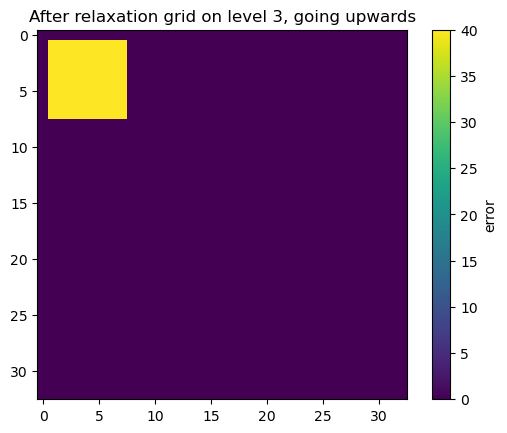

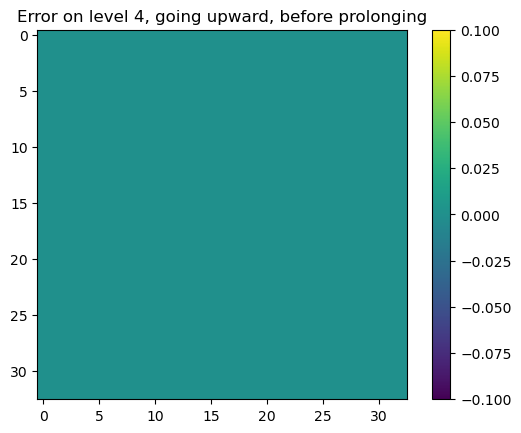

prolongation step from (33, 33) to (65, 65)
* * * * * * * * * * * * * *


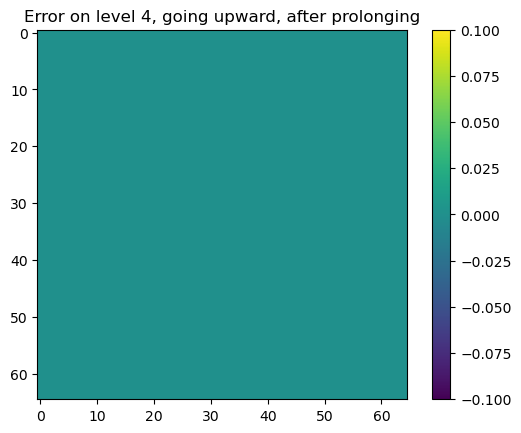

heater_patch shape is: (16, 16)
grid shape is: (65, 65)


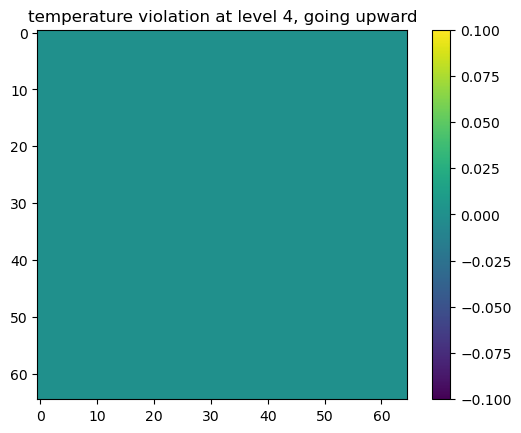

heater_patch shape is: (16, 16)
grid shape is: (65, 65)


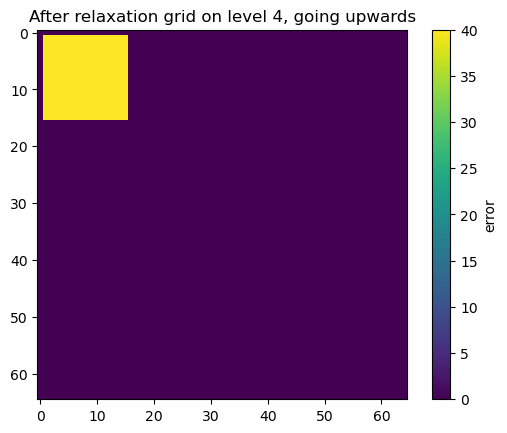

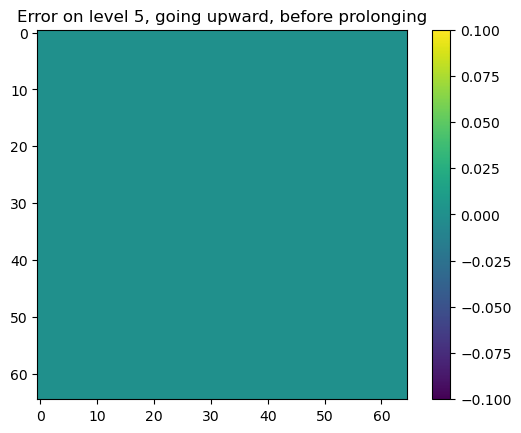

prolongation step from (65, 65) to (129, 129)
* * * * * * * * * * * * * *


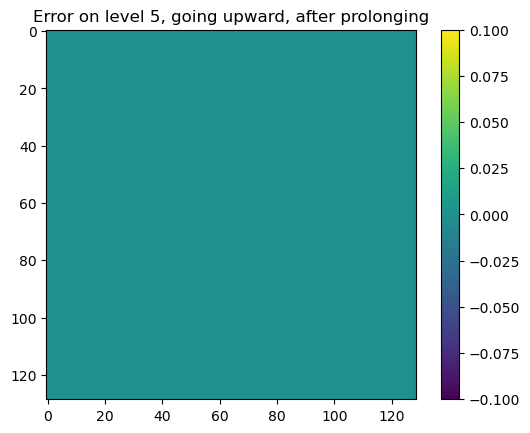

heater_patch shape is: (32, 32)
grid shape is: (129, 129)


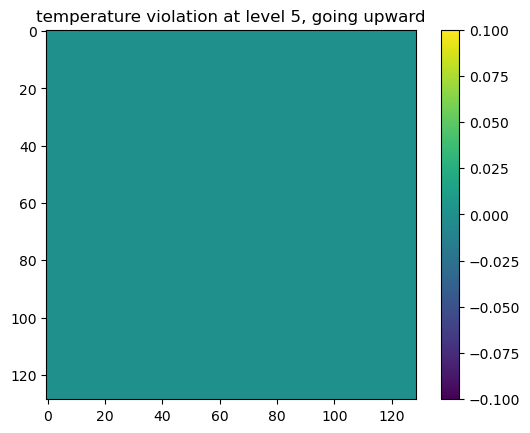

heater_patch shape is: (32, 32)
grid shape is: (129, 129)


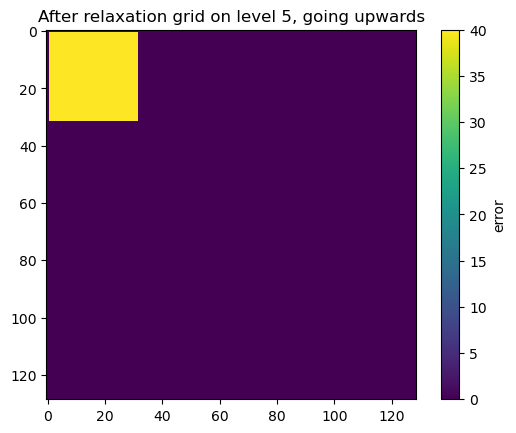

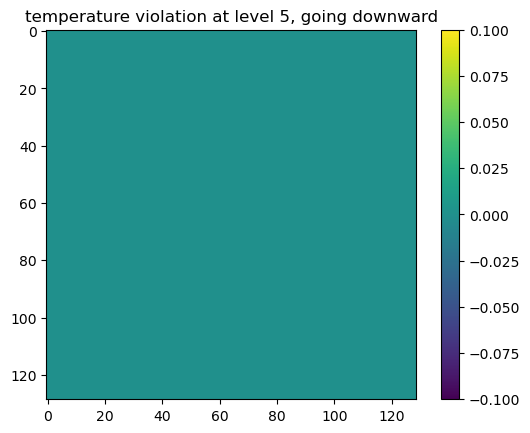

heater_patch shape is: (32, 32)
grid shape is: (129, 129)
restriction step from (129, 129) to (65, 65)
* * * * * * * * * * *


KeyboardInterrupt: 

In [119]:
import numpy as np
import matplotlib.pyplot as plt


def in_heater(i, j, N, padding = 0):
    """
    returns a boolean indicating whether or not we're in the region of the heater.
    UPDATE: calculates PHYSICAL coordinates of i, j, in [0,1] x [0,1]
    UPDATE: Added padding due to the discontinuity jump of the square heater.
    """
    x = i / (N - 1)
    y = j / (N - 1)
    
    return x <= 0.25 + padding  and y <= 0.25 + padding


def on_boundary(i, j, N):
    """
    returns a boolean indicating whether or not we're on the boundary of the region  
    """
    return i==0 or j==0 or i==N or j==N

def apply_heater(grid):
    """
    Injects the heater into the appropriate cells in the grid
    """
    n = grid.shape[0]
    ramp = np.linspace(40, 40, n//4)
    heater_patch = 0.5 * (ramp[:, None] + ramp[None, :])  # 2D average ramp
    print("heater_patch shape is:", heater_patch.shape)
    print("grid shape is:", grid.shape)
    grid[0:n//4, 0:n//4] = heater_patch
    
def relax(grid, rhs, omega=0.6, max_iter=100):
    """
    Performs Gauss-Seidel smoothing (relaxation)
    """
    n = grid.shape[0]
    h = 1 / (n-1)
    for _ in range(max_iter):
        for i in range(1, n-1):
            for j in range(1, n-1):
                if in_heater(i, j, n-1, 1/(n-1)) or on_boundary(i, j, n-1):
                    continue
                else:
                    grid[i, j] = (1 - omega) * grid[i, j] + omega * 0.25 * (
                                grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + 
                                grid[i, j+1] - (h**2)*rhs[i, j])
                if np.linalg.norm(grid) < 0.001:
                    break
    # Enforce boundary conditions
    apply_heater(grid)  # Reapply heater temperature in the top-left corner
    grid[0, :] = 0.0  # Enforce bottom boundary condition
    grid[-1, :] = 0.0  # Enforce top boundary condition
    grid[:, 0] = 0.0  # Enforce left boundary condition
    grid[:, -1] = 0.0  # Enforce right boundary condition
    

def restrict(grid):
    """Restrict grid to a coarser grid."""
    # plt.imshow(grid, cmap='viridis', interpolation='nearest')
    # plt.colorbar(label='Temperature (Celsius)')
    # plt.title('before restriction')
    # plt.show()
    n = grid.shape[0]
    coarse = np.zeros((n//2 + 1, n//2 + 1))
    for i in range(1, coarse.shape[0]-1):
        for j in range(1, coarse.shape[1]-1):
            fi, fj = 2 * i, 2 * j

            # if in_heater(fi, fj, n) or on_boundary(fi, fj, n):
            #     # injection (copying and pasting the same values, no smoothing / stenciling)
            #     # We're using this if we're in the heater or on the boundary
            #     coarse[i, j] = grid[fi, fj]
            # else:
            #     # 9-point stencil
            #     # if we're not on the boundary or heater, use the 9-point stencil
            #     coarse[i, j] = (
            #         1/16 * grid[fi-1, fj-1] + 1/8 * grid[fi-1, fj] + 1/16 * grid[fi-1, fj+1] +
            #         1/8  * grid[fi,   fj-1] + 1/4 * grid[fi,   fj] + 1/8  * grid[fi,   fj+1] +
            #         1/16 * grid[fi+1, fj-1] + 1/8 * grid[fi+1, fj] + 1/16 * grid[fi+1, fj+1]
            #     )

            coarse[i, j] = (
                    1/16 * grid[fi-1, fj-1] + 1/8 * grid[fi-1, fj] + 1/16 * grid[fi-1, fj+1] +
                    1/8  * grid[fi,   fj-1] + 1/4 * grid[fi,   fj] + 1/8  * grid[fi,   fj+1] +
                    1/16 * grid[fi+1, fj-1] + 1/8 * grid[fi+1, fj] + 1/16 * grid[fi+1, fj+1]
                )
            # 4-point stencil
            # coarse[i, j] = 0.25 * (grid[2*i, 2*j] + grid[2*i-1, 2*j] + grid[2*i, 2*j-1] + grid[2*i-1, 2*j-1])

            
    print(f"restriction step from {grid.shape} to {coarse.shape}")
    print("* * * * * * * * * * *")

    # plt.imshow(coarse, cmap='viridis', interpolation='nearest')
    # plt.colorbar(label='Temperature (Celsius)')
    # plt.title('after restriction')
    # plt.show()
    return coarse


def prolong(coarse):
    """Prolong coarse grid to a finer grid."""
    
    n = coarse.shape[0]
    fine = np.zeros((2*n - 1, 2*n - 1))
    for i in range(n - 1):  # avoid last row/col
        for j in range(n - 1):
            fi, fj = 2*i, 2*j

            # Copy coarse grid point to fine grid
            fine[fi, fj] = coarse[i, j]

            # Interpolate in x-direction (vertical midpoints)
            fine[fi+1, fj] = 0.5 * (coarse[i, j] + coarse[i+1, j])

            # Interpolate in y-direction (horizontal midpoints)
            fine[fi, fj+1] = 0.5 * (coarse[i, j] + coarse[i, j+1])

            # Interpolate center point (between 4 coarse grid points)
            fine[fi+1, fj+1] = 0.25 * (coarse[i, j] + coarse[i+1, j] +
                                       coarse[i, j+1] + coarse[i+1, j+1])
    print(f"prolongation step from {coarse.shape} to {fine.shape}")
    print("* * * * * * * * * * * * * *")
    
    

    return fine


def compute_residual(grid, rhs):
    n  = grid.shape[0] # dealing with a square grid
    residual = np.zeros_like(grid)

    for i in range(1, n - 1):
        for j in range(1, n - 1):
            
            if in_heater(i, j, n-1, 1/(n-1)):
                continue  # don't apply stencil
            elif on_boundary(i, j, n-1):
                grid[i, j] = 0.0   # Fixed wall BC
            else:
                laplace = -(4 * grid[i, j]
                        - grid[i-1, j]  # up
                        - grid[i+1, j]  # down
                        - grid[i, j-1]  # left
                        - grid[i, j+1]) # right

                residual[i, j] = rhs[i, j] - laplace

    return residual


def get_temperature_violation_mask(grid, max_allowed_temp=40.0, heater_mask=None):
    """
    Returns a boolean array where temperature exceeds the allowed max (outside the heater).

    Parameters:
    - grid: 2D NumPy array of temperatures
    - max_allowed_temp: Maximum allowed temperature (e.g., heater temp)
    - heater_mask: Optional 2D boolean array where True indicates heater region

    Returns:
    - violation_mask: Boolean array of same shape as grid
                      True where temperature exceeds max (excluding heater zone)
    """
    if heater_mask is not None:
        check_region = ~heater_mask  # only check outside heater
    else:
        check_region = np.ones_like(grid, dtype=bool)

    violation_mask = (grid > max_allowed_temp) & check_region
    return violation_mask
    

def multigrid(grid, rhs, levels, omega=0.6, iterations=10):
    """
    Multigrid V-cycle.
    
    """
    violation_mask = get_temperature_violation_mask(grid)

    plt.imshow(violation_mask)
    plt.title(f"temperature violation at level {levels}, going downward")
    plt.colorbar()
    plt.show()

    
    if levels == 1:
        relax(grid, rhs, omega, iterations)
        
        return grid

    # Pre-smoothing
    relax(grid, rhs, omega, iterations)

    # Compute residual
    # residual = rhs - (4 * grid[1:-1, 1:-1] - grid[:-2, 1:-1] - grid[2:, 1:-1] - grid[1:-1, :-2] - grid[1:-1, 2:])
    residual = compute_residual(grid, rhs)
    # residual = np.pad(residual, 1, mode='constant')

    # Restrict residual to coarser grid
    # print("the shape of the residual is", residual.shape)
    # print("the shape of the grid is", grid.shape)
    coarse_residual = restrict(residual)
    
    plt.imshow(coarse_residual)
    plt.title(f"Error on level {levels}, going downward")
    plt.colorbar()
    plt.show()
    

    N = coarse_residual.shape[0]
    for i in range(N):
        for j in range(N):
            if in_heater(i, j, N):
                coarse_residual[i, j] = 0.0

    
    # Solve on coarser grid
    coarse_grid = np.zeros_like(coarse_residual)
    # coarse_grid = restrict(grid)
    
    correction = multigrid(coarse_grid, coarse_residual, levels - 1, omega, iterations*4)
    N = correction.shape[0]
    for i in range(0, N):
        for j in range(0, N):
            if in_heater(i, j, N, 1/(N-1)) or on_boundary(i, j, N):
                correction[i, j] = 0
                
    plt.imshow(correction)
    plt.title(f"Error on level {levels}, going upward, before prolonging")
    plt.colorbar()
    plt.show()
    
    # Prolong correction to finer grid
    correction = prolong(correction)
    
    plt.imshow(correction)
    plt.title(f"Error on level {levels}, going upward, after prolonging")
    plt.colorbar()
    plt.show()
    correction[0:n//4, 0:n//4] = 0 # we don't need to add correction to the fixed heater zone

    
    # plotting
    # plt.imshow(grid, cmap='viridis', interpolation='nearest')
    # plt.colorbar(label='error')
    # plt.title(f'Before Adding correction grid (Level {levels}, Size {grid.shape})')
    # plt.show()
    
    
    
    # Apply correction
    grid = np.add(grid, correction)

    # reinforcing heater region and boundary conditions
    # grid[0:n//4, 0:n//4] = 40.0
    # grid[0, :] = 0.0
    # grid[-1, :] = 0.0
    # grid[:, 0] = 0.0
    # grid[:, -1] = 0.0
    apply_heater(grid)


    violation_mask = get_temperature_violation_mask(grid)

    plt.imshow(violation_mask)
    plt.title(f"temperature violation at level {levels}, going upward")
    plt.colorbar()
    plt.show()
    
    fine_level = compute_residual(grid, rhs)


    # plotting
    # plt.imshow(grid, cmap='viridis', interpolation='nearest')
    # plt.colorbar(label='error')
    # plt.title(f'After correction, before relaxation grid (Level {levels}, Size {grid.shape})')
    # plt.show()

    # Post-smoothing
    relax(grid, rhs, omega, iterations)
    fine_level = compute_residual(grid, rhs)

    # plotting
    plt.imshow(grid, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='error')
    plt.title(f'After relaxation grid on level {levels}, going upwards')
    plt.show()

    return grid



#  document and print error at each level (once during restriction, once during interpolation)
"""
At each level going down the V-cycle, compute the L2 norm of the residual and store it / print it
"""


# Example usage
n = 129  # Grid size
levels = 5  # Multigrid levels
grid = np.full((n, n), 0)
apply_heater(grid) # Heater in the top-left corner

grid[0, :] = 0.0  # Set bottom boundary condition
grid[-1, :] = 0.0  # Set top boundary condition
grid[:, 0] = 0.0  # Set left boundary condition
grid[:, -1] = 0.0  # Set right boundary condition

initial = grid.copy()
rhs = np.zeros((n, n))

solution = multigrid(grid, rhs, levels)

for cycles in range(5):
    solution = multigrid(solution, rhs, levels)
print(type(solution))

plt.imshow(initial, cmap='viridis', interpolation='nearest', vmin=0, vmax=60)  # Plot initial condition
plt.colorbar(label='Temperature (Celsius)')
plt.title('Initial Condition')
plt.show()

plt.imshow(solution, cmap='viridis', interpolation='nearest', vmin=0, vmax=60)
plt.colorbar(label='Temperature (Celsius)')
plt.title('Multigrid Solution')
plt.show()